# Final Mini Project Report: Music Genre Classification

#### Michael Miceli, Kaden Franklin, Scott Brown, Ty Hawkes

## Introduction
Around 120,000 new music tracks are uploaded to streaming services every day. Due to the increasingly high number of songs produced now days, it is time consuming and expensive for humans to listen to each song and classify its genre. Classifying new tracks into correct genres allows streaming services to recommend these tracks to audiences that are more likely to enjoy them. In this project, we aim to develop a predictive model that can take an audio sample, and accurately classify it's genre without the need of a human ear. We will evaluate our models using the accuracy metric, as our ten genre classes are perfectly balanced.

We learned that in real-world audio processing, models seldom analyze audio files (.wav, .mp3, etc.) directly. Instead, they first encode the audio files into an image called a *spectrogram*. This visualization shows the strength of the audio signal (y axis) over time (x axis) and is similar to a waveform. Image classification models, such as convolutional neural network and vision transformers, are then applied directly to the spectrogram to perform classification or analysis. 

Much of the "art" of real-world audio processing is finding the most effective way to encode audio into a spectrogram. We explored various techniques for directly encoding our .wav files to spectrograms, but ultimately decided to analyze the spectrograms already included in the GTZAN dataset.

Thus, our modeling focused on a three-pronged approach to classifying the music into genres. First, we decided to create an ensemble of traditional supervised models to analyze the tabular data included in the GTZAN dataset (track audio features, etc.). Secondly, we tried a more traditional image analysis approach with a convolutional neural network classifying the spectrogram images. Finally, we decided to try experiment exploring vision transformers, an advanced but complex new technique with which we did not have previous experience.

## Exploratory Data Analysis

In [4]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import seaborn as sns

# Import data
df_3 = pd.read_csv('data/features_3_sec.csv')
df_30 = pd.read_csv('data/features_30_sec.csv')
df_numeric = df_30.drop(columns=['filename', 'label'])

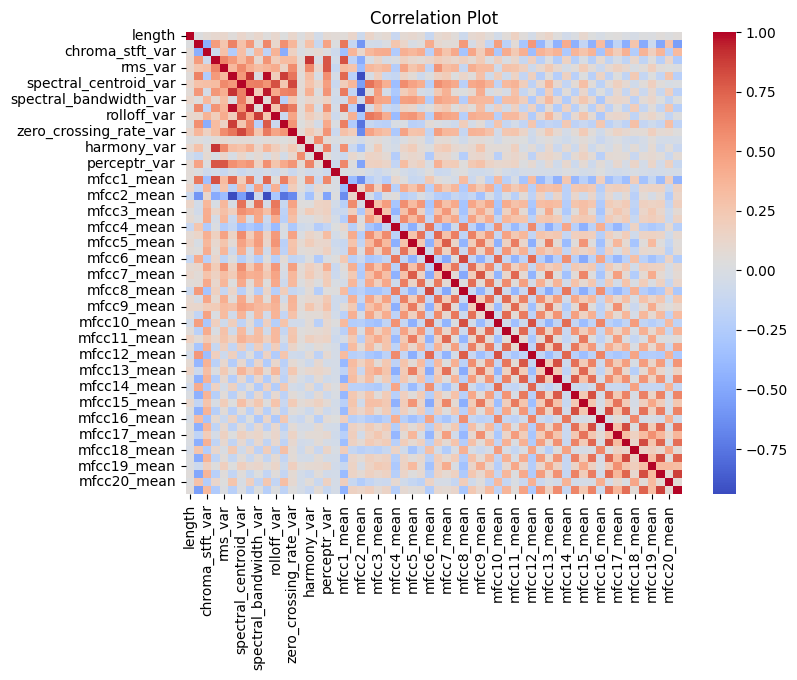

In [14]:
corr_matrix = df_numeric.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})

## Rotate bottom labels 45 degrees
#plt.xticks(rotation=70)

plt.title('Correlation Plot')
plt.show()

/tmp/ipykernel_16138/3117084275.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'label', y = 'tempo', data = lable_tempo_df, palette = 'rocket' )


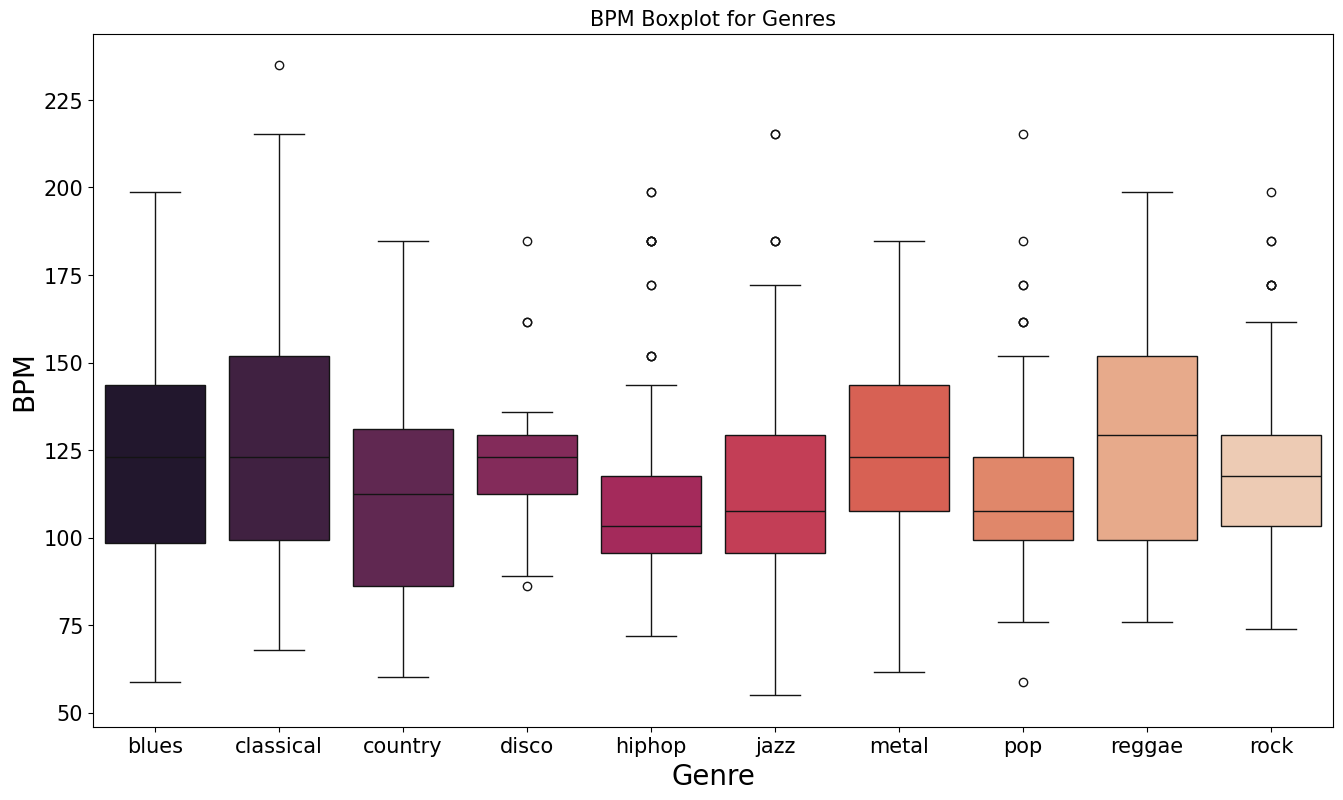

In [7]:
lable_tempo_df= df_30[['label', 'tempo']]

f, ax = plt.subplots(figsize = (16,9))
sns.boxplot(x = 'label', y = 'tempo', data = lable_tempo_df, palette = 'rocket' )

plt.title('BPM Boxplot for Genres', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Genre', fontsize = 20)
plt.ylabel('BPM', fontsize = 20)
plt.show()

Our data has no missing values. Classical and reggae have the highest average BPM, while pop and hip hop have the lowest BPM. Disco, unsuprisingly, has the least variation in tempo because the beat of disco music is intentionally consistent across songs in the genre. Our features exhibit subtantial multicollinearity, but we do not expect this to be an issue for nonparametric ML models.

Example spectrograms

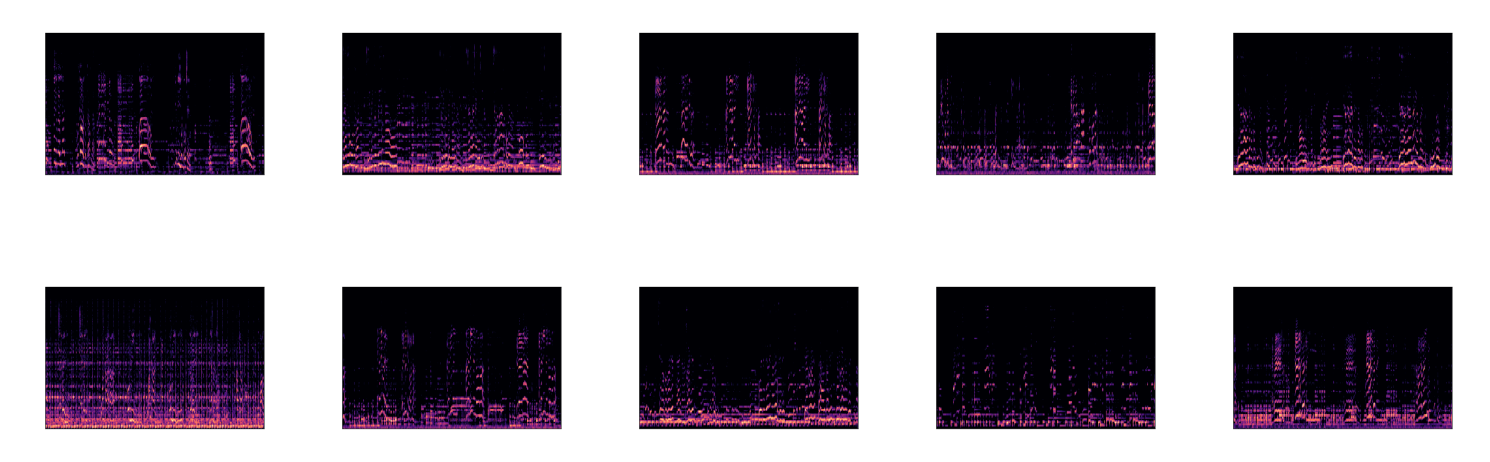

In [3]:
directory_path = "data/images_original/blues/"
image_files = [f for f in os.listdir(directory_path) if f.endswith('.png')]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
axes = axes.flatten()
for ax, image_file in zip(axes, image_files[:10]):
    image = mpimg.imread(os.path.join(directory_path, image_file))
    ax.imshow(image)
    ax.axis('off') 

plt.tight_layout()
plt.show()

## Methods

### Advanced EDA and Feature Engineering

**Compression Reduction** - We compressed each audio file using FLAC lossless compression and then recorded the percent reduction of file size for each file. We believed this would help identify music genres if some genres were more repetative than others. Our EDA showed that Classical and Jazz had the highest average file size reductions, while pop had the lowest average file size reductions. Intuitively, we hoped this feature would convey information about the repetition or audio sparsity (number of instruments, etc.) present in a track, which might differ between geres. When we included this feature in our traditional models, it generally increased the accuracy by a few percentage points regardless of the method. 

In [6]:
import plotly.express as px

df = pd.read_csv('data/compression_feature.csv')
df['genre'] = df['filename'].str.extract((r'([a-z]+)'))
df_grouped = df.groupby('genre').mean(numeric_only=True).reset_index()
df_grouped = df_grouped.sort_values('compression_reduction', ascending=False)
fig = px.bar(x = df_grouped['genre'], y = df_grouped['compression_reduction'])
fig.update_layout(
    title='Average lossless compression by genre',
    xaxis_title='Genre',
    yaxis_title='Percent reduction'
)
fig.show()

### All Models 

**Random Forest**  
&emsp;**Description**  
&emsp; - Ensemble learning method that builds multiple decision trees to classify its input.  
&emsp;**Key Hyper Parameters**  
&emsp;- n_estimators: Number of decision tree to build  
&emsp;- max_depth: Maximum depth allowed for each tree  
&emsp;- min_samples_split: Minimum number of observations allowed in a node to allow a split  
&emsp;- min_samples_leaf: Minimum number of observations allowed in a leaf node of a tree.  
&emsp;**Results**  
&emsp;- 56% accuracy. Had the hardest time classifying Reggae and Jazz.

**K Nearest Neighbors**  
&emsp;**Description**  
&emsp; - Simple, non-parametric algorithm that predicts labels based on the majority vote of it's K nearest neighbors in the feature space.  
&emsp;**Hyper Parameters**  
&emsp;- n_neighbors: Number of neighbors involved in vote ranked by their closeness in proximity.  
&emsp;- weights (uniform, distance): Determines the weight of each vote based on their rank.  
&emsp;- metric: Determines how distance is calculated.  
&emsp;**Results**  
&emsp;- 45% accuracy. Struggled to classify reggae.

**Support Vector Machines**  
&emsp;**Description**  
&emsp; - Simple algorithm that finds the optimal hyperplane that maximizes the margin between different classes in feature space.  
&emsp;**Hyper Parameters**  
&emsp;- C: Regularization parameter (Higher C leads to overfitting)  
&emsp;- kernel (linear, rbf, poly): Determines the kind of shape that the decision boundary can follow.  
&emsp;- gamma (scale, auto): Determines how many datapoints are considered when determining the optimal boundary  
&emsp;**Results**  
&emsp;- 56% accuracy. Had a hard time classifying Rock and Disco

**XGBoost GBM**  
&emsp;**Description**  
&emsp; - Ensemble learning method that builds multiple weak decision trees sequentially on the residuals of the previous decision tree's predictions.  
&emsp;**Key Hyper Parameters**  
&emsp;- n_estimators: Number of decision tree to build.  
&emsp;- max_depth: Maximum depth allowed for each tree.  
&emsp;- learning_rate: The speed at which the model corrects it's previous errors.  
&emsp;**Results**  
&emsp;- 55% accuracy. Had the hardest time classifying Disco and Rock.

**Convolutional Neural Network**  
&emsp;**Description**  
&emsp;- Deep learning model primarily used for analyzing visual imagery (in our case, spectrograms).  
&emsp;**Hyper Parameters**  
&emsp;- Learning Rate: Adjusts the amount by which weights are changed from epoch to epoch.  
&emsp;**Results**  
&emsp;- 68% accuracy. 

**Transformers**  
&emsp;**Description**  
&emsp; - Deep learning artichtecture that relies on self-attention mechanisms to process sequences of data.  
&emsp;**Hyper Parameters**  
&emsp;- Learning Rate: Adjusts the amount by which weights are changed from epoch to epoch.  
&emsp;- Batch Size: number of samples processed before weights are updated.  
&emsp;- Additional hyperparameters include validation split, image size, n epochs, transformer layers, patch size, projection dim, num heads, transformer units, mlp head units.  
&emsp;**Results**  
&emsp;- 20% accuracy. We achieved slightly better than random guessing, but generally did not find success with this model. 

Ultimately, the ensemble of traditional models achieved comparable accuracy to each model in isolation. Only KNN exhibited significantly poorer results, and all other traditional models achieved an accuracy around 55% (as did the ensemble).

## Model Selection

### Patterns
To our surprise, we observed that the CNN performed better than our traditional machine learning methods. Our traditional methods saw an accuracy around 55% compared to the 68% accuracy of our CNN. Additionally, each traditional machine learning method yielded a very similar accuracy despite the large differences in their algorithms. Lastly, we did not expect the random forest or support vector machine to have comparable performance to our gradient boosted tree ensemble method. 

### Pit-falls
Though we did not experience much trouble with traditional methods or CNN, we struggled to do better than random guessing with our transformer. It was difficult to find appropriate hyperparameters for our transformer model, and it was generally slow to train compared to other deep learning algorithms with a similar number of layers. Designing the transformer architecture also proved extremely challenging as most available educational resources on transformers are aimed at an advanced academic audience and were difficult to parse. 

For the transformer, we tried both a custom-built architecture and transfer learning. Transfer learning using HuggingFace models proved difficult for two reasons. Firstly, we had to pay careful attention to avoid data leakage in transfer learning; the GTZAN dataset is well known, and many spectrogram-oriented base models had already trained on it. Even more challenging, we were not able to integrate TensorFlow and Keras with HuggingFace. Attempting to do so led to numerous versioning errors and tensor-type mismatches (the latest version of the libraries are not compatible). After extensive debugging, we finally opted to use PyTorch for the transfer learning, which was feasible but required us to learn the intricacies of PyTorch. Ultimately, Transformers proved a useful experiment and we learned a great deal, but they did not perform well enough to merit their substantial time investment. 

Additionally, we ran into trouble with our CNN model because it started to overfit quickly to our training data, leading to a stagnant validation accuracy of 60-70%. We tried adding additional regularization, but this caused the model to underfit even with only slightly more dropout and various different optimizers.

### Possible Explanations for Poor Model Performance
**Transformer** - We believe this model underperformed due to our lack of understanding/experience implementing transformers, and to our lack of training data. We only had 100 spectrograms per category which is very small for a deep learning model -- *especially* a transformer -- to perform well.  
**CNN** - Like with the transformer model, we believe we lacked sufficient training data for this model to generalize above the 60% accuracy it achieved. It began to overfit very quickly and we could not prevent that without additional data as our regularization did not work well.

## Best Model and performance

### Hyper Parameter Tuning
  
&emsp;- Learning Rate: Adjusts the amount by which weights are changed from epoch to epoch. We used a learning rate of 0.001 because it is large enough to run quickly, but small enough not to get stuck in local minima of our gradient.  
&emsp;- Optimizer: SGD (stocastic gradient descent). We selected SGD because other optimers got stuck in local minima.  
&emsp;- Epochs / Batch Size: 500 w/ Early Stopping / 32. We used 500 epochs with early stopped to let the model run long enough to find patterns, but stop before it overfit too badly. We used a standard batch size of 32.  
&emsp;- Activation Function: ReLU (hidden layers), Softmax (output function). We used ReLU to introduce non-linearity.

Additionally, we performed tuning to prevent the CNN from overfitting. However, increasing the regularization and adjusting the optimizer did not improve our out-of-sample accuracy. Our CNN achieved a training accuracy of 97% and a testing accuracy of 68%. Although the model clearly overfit the training data, any additional regularization we added to prevent this also resulted in a lower test score. We especially tried varying the amount of dropout between layers and using a different optimizer (AdamW instead of SGD), but in each case the model underfit or got stuck in local minima.

Rock and country were most often confused across all models; a sample confusion matrix for XGBoost is shown below.

![XGBoost Confusion Matrix](resources/xgboost_confusion.png "XGBoost Confusion Matrix")

**XGBoost Confusion Matrix with counts of each classification. X axis is prediction, y axis is truth. The diagonal corresponds to accuracy.**


## Conclusion & Next Steps

Ultimately, we achieved good but not excellent classification results. We learned the nuances of analyzing audio files, including spectrogram processing and compression techniques. We found it difficult to perform EDA on audio data, but found analying the average compression by genre especially insightful in revealing which audio patterns a model might pick up on. Finally, our foray into transformers proved extremely difficult to implement effectively, but we nevertheless learned a great deal about their architecture, hyperparameters, and foundational theory.

In the future, we would be interested in expanding our analysis by combining our traditional ensemble with our CNN. We believe this combination would yield superior predictions since they rely on different types of data. Finally, we would like to learn more about transformers to see if we they can beat the performance of our ensemble or CNN, as trasnformers are powerful models but will require much greater learning to fully utilize.

# Appendix: Project Requirements

1. Significant feature engineering: engineered degree of lossless compression possible for each track as new feature to indicate repetition and audio sparsity
2. Implementation of at least four standard supervised machine learning models: Random Forest, KNN, SVM, LightGBM
3. Implementation of a deep learning model with detailed hyperparameter tuning: CNN
3. Use of a significant ML method we didn't learn in class: vision transformers (and, more generally, audio processing)
